# RAVDESS EDA 

In [1]:
# Core imports
import os
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

# Optional: reduce notebook backend-related issues (safe)
try:
    from matplotlib_inline.backend_inline import set_matplotlib_close
    set_matplotlib_close(False)
except Exception:
    pass


In [2]:
# Dataset root (update if needed)
RAVDESS_ROOT = "/Users/malakmaher/Documents/GitHub/Emotion-Recognition/dataset/archive"

assert os.path.exists(RAVDESS_ROOT), f"Path not found: {RAVDESS_ROOT}"

# Collect WAV paths
rows = []
for root, _, files in os.walk(RAVDESS_ROOT):
    for f in files:
        if f.lower().endswith(".wav"):
            rows.append(os.path.join(root, f))

print("Found .wav files:", len(rows))
print("Example:", rows[0] if rows else "No wav files found")


Found .wav files: 2781
Example: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/dataset/archive/Actor_16/03-01-05-01-02-01-16.wav


In [3]:
# Build a clean dataframe
EMOTION_MAP = {
    1: "neutral",
    2: "calm",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "fearful",
    7: "disgust",
    8: "surprised",
}

def parse_ravdess_ids(path: str):
    """Return (emotion_id, actor_id) from a RAVDESS filename like 03-01-05-02-02-01-12.wav"""
    base = os.path.basename(path)
    stem = os.path.splitext(base)[0]
    parts = stem.split("-")
    if len(parts) < 7:
        return (None, None)
    try:
        emotion_id = int(parts[2])
        actor_id = int(parts[6])
        return (emotion_id, actor_id)
    except ValueError:
        return (None, None)

df = pd.DataFrame({"file": rows})
df[["emotion_id", "actor_id"]] = df["file"].apply(lambda p: pd.Series(parse_ravdess_ids(p)))
df["emotion"] = df["emotion_id"].map(EMOTION_MAP)

# Drop bad parses
df = df.dropna(subset=["file", "emotion", "emotion_id", "actor_id"]).copy()
df["emotion_id"] = df["emotion_id"].astype(int)
df["actor_id"] = df["actor_id"].astype(int)

df.head()


,file,emotion_id,actor_id,emotion
0,/Users/malakmaher/Documents/GitHub/Emotion-Rec...,5,16,angry
1,/Users/malakmaher/Documents/GitHub/Emotion-Rec...,6,16,fearful
2,/Users/malakmaher/Documents/GitHub/Emotion-Rec...,6,16,fearful
3,/Users/malakmaher/Documents/GitHub/Emotion-Rec...,5,16,angry
4,/Users/malakmaher/Documents/GitHub/Emotion-Rec...,7,16,disgust


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'angry'),
  Text(1, 0, 'calm'),
  Text(2, 0, 'disgust'),
  Text(3, 0, 'sad'),
  Text(4, 0, 'happy'),
  Text(5, 0, 'fearful'),
  Text(6, 0, 'surprised'),
  Text(7, 0, 'neutral')])

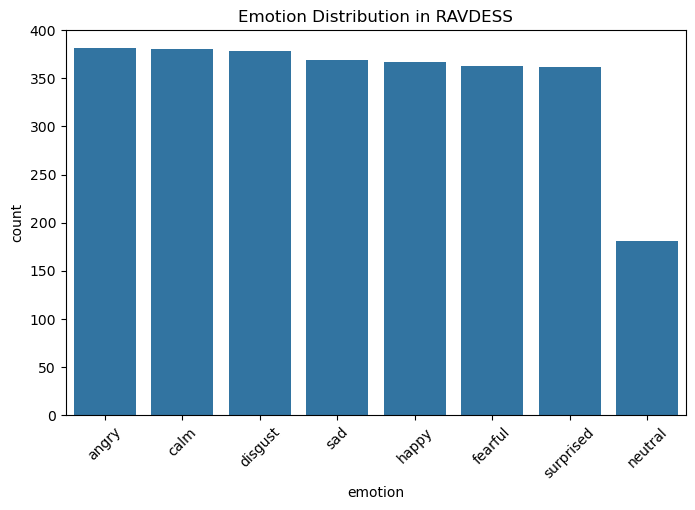

In [4]:
# Emotion distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="emotion", order=df["emotion"].value_counts().index)
plt.title("Emotion Distribution in RAVDESS")
plt.xticks(rotation=45)


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23'),
  Text(23, 0, '24')])

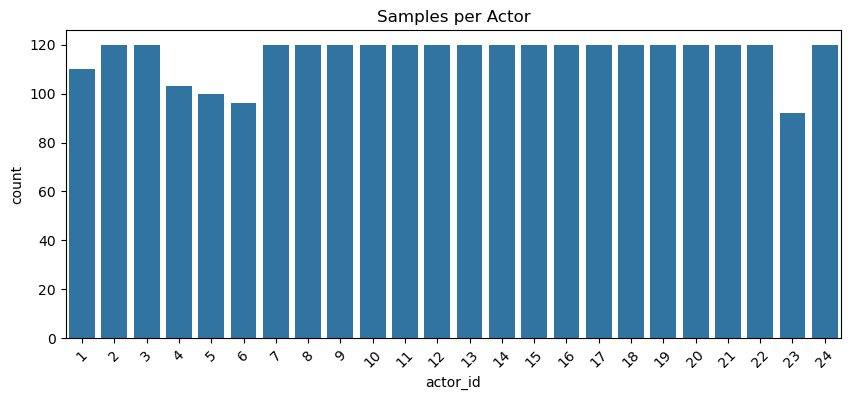

In [5]:
# Samples per actor
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="actor_id", order=sorted(df["actor_id"].unique()))
plt.title("Samples per Actor")
plt.xticks(rotation=45)


count    2781.000000
mean        3.711643
std         0.333957
min         2.936271
25%         3.503500
50%         3.670333
75%         3.870542
max         5.271937
Name: duration, dtype: float64

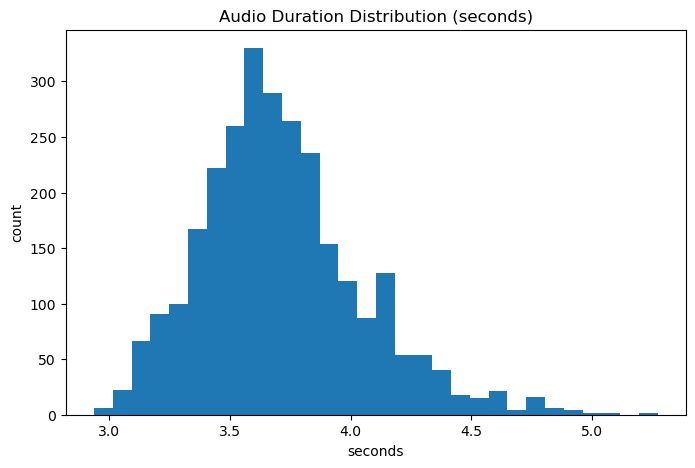

In [6]:
# Audio duration distribution (seconds)
durations = []
for f in df["file"]:
    audio, sr = librosa.load(f, sr=None, mono=True)
    durations.append(len(audio) / sr)

df["duration"] = durations

plt.figure(figsize=(8, 5))
plt.hist(df["duration"], bins=30)
plt.title("Audio Duration Distribution (seconds)")
plt.xlabel("seconds")
plt.ylabel("count")

df["duration"].describe()


Text(0.5, 1.0, 'Waveform Example (angry)')

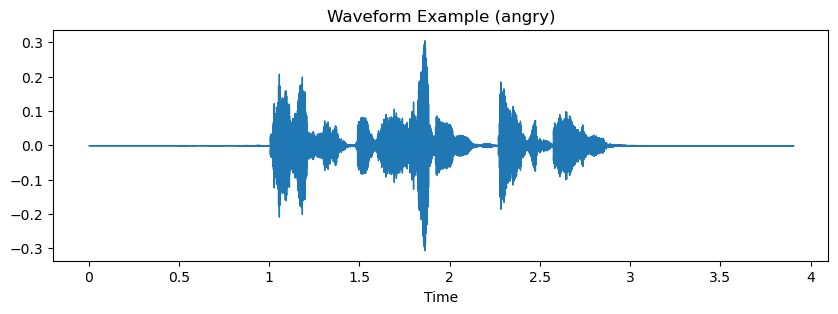

In [7]:
# Waveform example (pick first available for an emotion)
target_emotion = "angry"
subset = df.loc[df["emotion"] == target_emotion, "file"]
if subset.empty:
    target_emotion = df["emotion"].iloc[0]
    subset = df.loc[df["emotion"] == target_emotion, "file"]

sample_file = subset.iloc[0]
audio, sr = librosa.load(sample_file, sr=None, mono=True)

plt.figure(figsize=(10, 3))
librosa.display.waveshow(audio, sr=sr)
plt.title(f"Waveform Example ({target_emotion})")


Text(0.5, 1.0, 'Log-Mel Spectrogram Example')

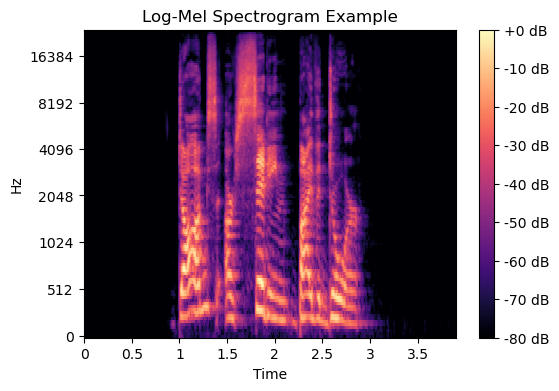

In [8]:
# Log-mel spectrogram example
mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
log_mel = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(6, 4))
librosa.display.specshow(log_mel, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram Example")


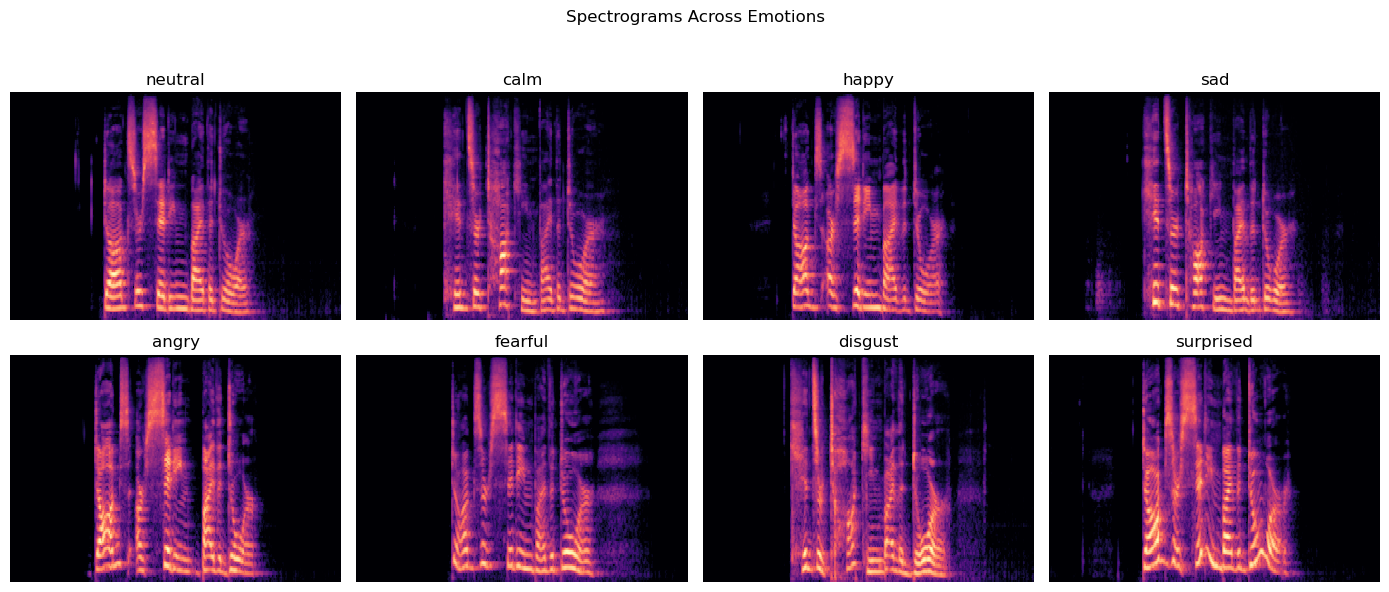

In [9]:
# Spectrogram grid across emotions (2x4)
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()

for ax, emotion in zip(axes, EMOTION_MAP.values()):
    subset = df.loc[df["emotion"] == emotion, "file"]
    if subset.empty:
        ax.set_title(f"{emotion} (missing)")
        ax.axis("off")
        continue

    f = subset.iloc[0]
    y, sr_local = librosa.load(f, sr=None, mono=True)

    mel = librosa.feature.melspectrogram(y=y, sr=sr_local, n_mels=128)
    log_mel = librosa.power_to_db(mel, ref=np.max)

    librosa.display.specshow(log_mel, sr=sr_local, x_axis=None, y_axis=None, ax=ax)
    ax.set_title(emotion)
    ax.axis("off")

fig.suptitle("Spectrograms Across Emotions")
fig.tight_layout(rect=[0, 0, 1, 0.95])
